# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "camille"
ln1 = "masset"
fn2 = "boris"
ln2 = "muzellec"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_masset_camille_and_muzellec_boris.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad d(x_{i},P(w,b)) = \frac{|w^{\top}x_{i}+b|}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$$
 \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}.
$$
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

#### Question 1

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

##### Answer

The objective function is quadratic ($\frac{1}{2}w^\top w = \frac{1}{2}\Vert w \Vert^2$) and thus convex, the conditions are linear and thus convex too, therefore problem $(\mathcal{P})$ is convex.

#### Question 2

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

##### Answer

The Lagrangian of the problem is:
$$\mathcal{L}(w, b, \mu) = \frac{1}{2} \Vert w \Vert^2 - \sum_{i=1}^n \mu_i [y_i(w^\top x_i + b) - 1]$$
Taking the derivative at a saddle point $(w, b, \mu)$, we have:
$$\frac{\partial \mathcal{L}}{\partial w} = w - \sum_{i=1}^n \mu_i y_i x_i = 0 \quad \text{and} \quad \frac{\partial \mathcal{L}}{\partial b} = - \sum_{i=1}^n \mu_i y_i = 0$$

Now we introduce the matrix $G = (y_i x_i^\top)_{1 \leq i \leq n} \in \mathcal{M}_{n,d}(\mathbb{R})$. We notice that:
$$G^\top \mu = \sum_{i=1}^n \mu_i y_i x_i = w \quad \text{at a saddle point of } \mathcal{L}$$

We subtitute these values in the general expression of the Lagragian, at a saddle point:
$$\mathcal{L}(w, b, \mu) = \frac{1}{2} \left( G^\top \mu \right)^\top \left( G^\top \mu \right) + \sum_{i=1}^n \mu_i - b \sum_{i=1}^n \mu_i y_i - \sum_{i=1}^n \mu_i y_i (G^\top \mu)^\top x_i$$

Therefore, with $u = (1, \dots, 1)^\top \in \mathbb{R}^n$:
$$\mathcal{L}(w, b, \mu) = \frac{1}{2} \left( G^\top \mu \right)^\top \left( G^\top \mu \right) + \mu^\top u - (G^\top \mu)^\top (G^\top \mu)$$
$$\mathcal{L}(w, b, \mu) = \frac{1}{2} \mu^\top G G^\top \mu + \mu^\top u - \mu^\top G G^\top \mu$$
Finally, at a saddle point, we have:
$$\mathcal{L}(w, b, \mu) = - \frac{1}{2} \mu^\top G G^\top \mu + \mu^\top u \quad \text{ and } \quad \mu^\top y = 0$$

Considering the optimisation problem $(\mathcal{P})$, which is convex with affine inequalities constraints (that are supposed qualified), we can apply the Kuhn and Tucker theorem:
$$(w, b) \text{ is a minimiser of } J(w,b) = \frac{1}{2}w^\top w \text{ with the constraints } -y_i(w^\top x_i+b) + 1 \leq 0$$
$$\implies \exists \mu \in \mathbb{R}^n \text{ s.t. } \mu \geq 0 \text{ and } ((w, b), \mu) \text{ is a saddle point of the Lagragian } \mathcal{L}$$

Therefore, we can consider the dual problem:
$$ (\mathcal{D}): \begin{cases}\max_\mu \left\lbrace -\frac{1}{2} \mu^\top G G^\top \mu + \mu^\top u \right\rbrace \\ \text{s.t. } \mu \geq 0 \\ \text{and } y^\top \mu = 0 \end{cases}$$
which is equivalent to:
$$ (\mathcal{D}): \begin{cases}\min_\mu \left\lbrace \frac{1}{2} \mu^\top G G^\top \mu - \mu^\top u \right\rbrace \\ \text{s.t. } -\mu \leq 0 \\ \text{and } y^\top \mu = 0 \end{cases} $$

#### Question 3

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

##### Answer

We have constructed the optimisation problem to find a function $f$ such that $y = f(x)$ where $f(x) = \mathrm{sg}(w^\top x + b)$. 
Moreover, we have derived previously that at the optimum:
$$ w = \sum_{i=1}^n \mu_i y_i x_i $$
It is then obvious that given the estimated $\mu$, the prediction for a new sample $x$ is given by:
$$ y = \mathrm{sg}\left( \sum_{i=1}^n \mu_i y_i x_i^\top x + b \right) $$ 

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [3]:
from svm_project_utils import plot_dataset, datasets

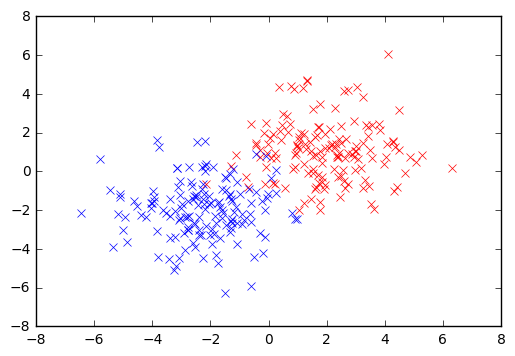

In [4]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [5]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 3


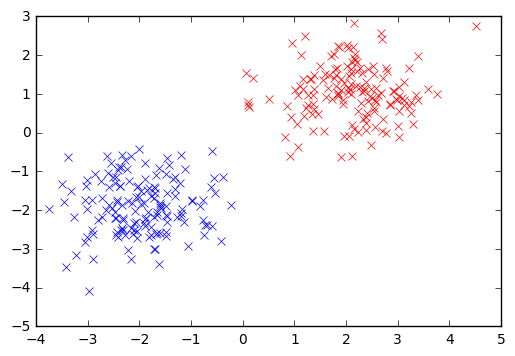

In [7]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

def svm_solver(K, y, C=np.inf):
    y = y.reshape((-1, 1))
    H = np.multiply(y.dot(y.T), K)
    e = np.array([1.] * y.shape[0]).reshape((-1, 1))
    A = y
    b = 0.
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

In [8]:
w = np.multiply(X[idx_support].T,y[idx_support]).dot(mu_support)

- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

##### Answer

The KKT conditions ensure that $\forall i$:
- either $\mu_i = 0$,
- or $y_i(w^\top x_i + b) = 1$

To find $b$, it therefore suffices to pick any index $i$ in the support of $\mu$, and deduce from the above that 
$$\begin{align} 
b &= y_i - w^\top x_i\\
&= y_i - \sum_{j=1}^n \mu_j y_j x_j^\top x_i
\end{align}$$

In [9]:
def compute_b(K, y, mu_support, idx_support):
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    b = y_support[0] -  np.sum(mu_support * y_support * K_support[0])
    return b

b = compute_b(K, y, mu_support, idx_support)

- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [10]:
def check(X, y, w, b, precision = 1e-5):
    return all(xi >= 1-precision for xi in (y * (X.dot(w) + b)))

print(check(X, y, w, b))

True


Check your code by running the following cell:

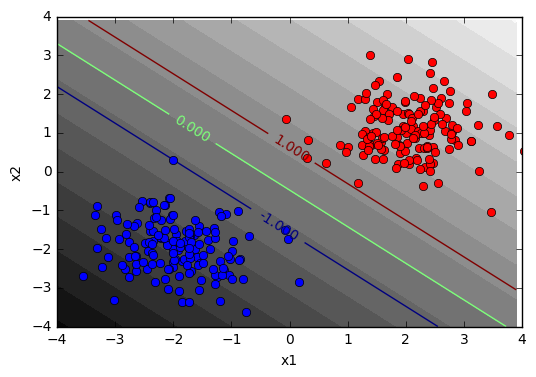

In [11]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

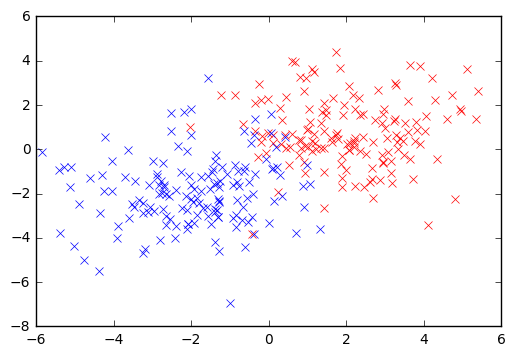

In [12]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [13]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

Terminated (singular KKT matrix).


- Q8: Check that contraints of the problem are now violated.

False


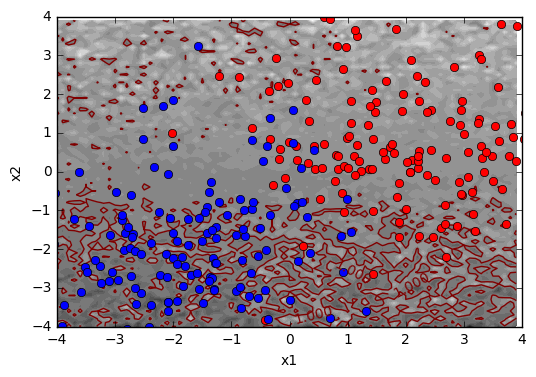

In [14]:
print(check(X, y, w, b))
plot_classif(X, y, mu_support, idx_support, b)

## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

##### Answer

$(P_s)$ is the minimization of a convex function of ($w,\xi$) under affine inequality constraints. It is therefore a convex problem.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

##### Answer

Introducing Lagrange multipliers $\mu, \alpha$ for the two types of inequality constraints, the Lagragian of $(P_s)$ is $\mathcal{L}(w,b,\xi,\mu,\alpha) =  \frac{1}{2}w^{\top}w + C \sum_i \xi_i - \sum_i \mu_i [(w^\top x_i + b) - (1-\xi_i)] - \sum_i \alpha_i \xi_i$

Since $(P_s)$ is a convex problem, its KKT conditions are necessary and sufficient. In particular, at an optimum the gradient of its Lagragian vanishes, which yields 
$\begin{align}
\nabla_w\mathcal{L}(w,b,\xi,\mu,\alpha) &= w - \sum_i\mu_i y_i x_i = 0\\
\frac{\partial\mathcal{L}(w,b,\xi,\mu,\alpha)}{\partial b} &= - \sum_i\mu_i y_i= 0\\
\nabla_\xi\mathcal{L}(w,b,\xi,\mu,\alpha) &= C\mathbb{1} - (\mu + \alpha) = 0
\end{align}$

i.e.

$\begin{align}
&w = G^\top \mu\\
&\mu^\top y = 0\\
&Cu = (\mu + \alpha)
\end{align}$

where $u$ is the vector of ones.

The KKT conditions also give us that

$\begin{align}
&\forall i, \mu_i[y_i(w^\top x_i +b) - (1 - \xi_i)] = 0\\
&\forall i, \alpha_i \mu_i = 0
&\forall i, \mu_i \geq 0, \alpha_i \geq 0, \alpha_i + \mu_i = 0
\end{align}$

In particular, we can rewrite the Lagrangian at the optimum as

$\begin{align}
\mathcal{L}(w,b,\xi,\mu,\alpha) &=  \frac{1}{2}\mu^\top GG^\top \mu + \sum_i \mu_i \xi_i - \sum_i \mu_i [(w^\top x_i + b) - (1-\xi_i)]\\
& = \frac{1}{2}\mu^\top GG^\top \mu - \sum_i \mu_i [(w^\top x_i + b) - 1]\\
& = \frac{1}{2}\mu^\top GG^\top \mu - \mu^\top GG^\top \mu + \mu^\top u\\
&= - \frac{1}{2}\mu^\top GG^\top \mu + \mu^\top u
\end{align}$

Therefore, we can consider the dual problem:
$$ (\mathcal{D}): \begin{cases}\max_\mu \left\lbrace -\frac{1}{2} \mu^\top G G^\top \mu + \mu^\top u \right\rbrace \\ \text{s.t. } \mu \geq 0, \alpha \geq 0, Cu = \alpha + \mu \text{ and } y^\top \mu = 0 \end{cases}$$
which is equivalent to:
$$ (\mathcal{D}): \begin{cases}\min_\mu \left\lbrace \frac{1}{2} \mu^\top G G^\top \mu - \mu^\top u \right\rbrace \\ \text{s.t. } 0 \leq \mu \leq C \\ \text{and } y^\top \mu = 0 \end{cases} $$


- Q10: Modify your code from Q4 to handle the non-separable case.

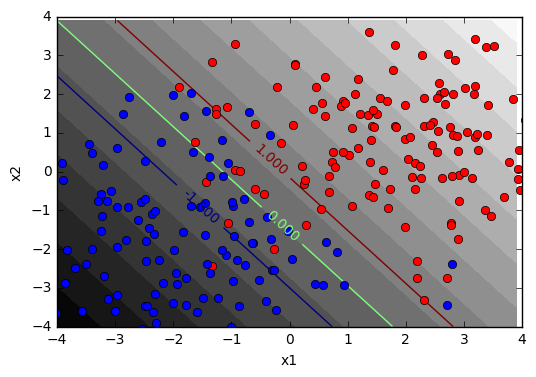

In [15]:
# TODO

X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K,y,C = 1)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b)

- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

ANSWER HERE

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$

##### Answer

Since $XX^\top_{ij} = \lbrace x_i,x_j\rbrace = K(x_i,x_j)$, we have that $GG^\top_{ij} = y_iK(x_i,x_j)y_j$ and therefore $\mu^\top GG^\top\mu = \sum_{ij} \mu_i y_i K(x_i,x_j)y_j \mu_j$.

Likewise, the decision function $f(x) = \mathrm{sg}(w^\top x + b)$ can be rewritten as

$\begin{align}
f(x) &= \mathrm{sg}(\mu^\top G x + b)\\
&= \mathrm{sg}\left( \sum_{i=1}^n \mu_i y_i x_i^\top x + b \right)\\
&= \mathrm{sg}\left( \sum_{i=1}^n \mu_i y_i K(x_i,x) + b \right)
\end{align}$

Both the minimization problem and the decision function can thus be reformulated in terms of kernel $K$.

We will use the clowns dataset to evaluate this:

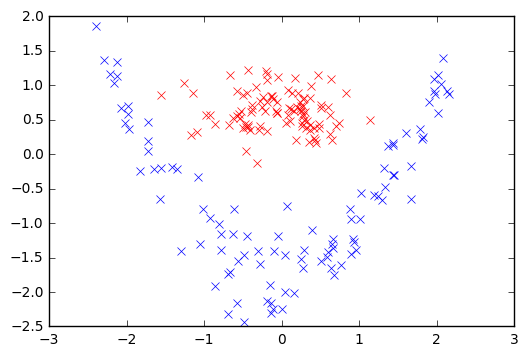

In [16]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [17]:

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma*np.linalg.norm(X1[i] - X2[j]))
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

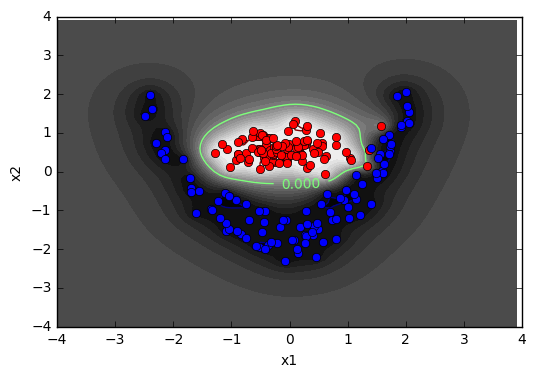

In [18]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

##### Answer

Introducing Lagrange multipliers $\mu, \alpha$ for the two types of inequality constraints, the Lagragian of $(P_s)$ is $\mathcal{L}(w,\xi,\mu,\alpha) =  \frac{1}{2}w^{\top}w + C \sum_i \xi_i - \sum_i \mu_i [(w^\top x_i) - (1-\xi_i)] - \sum_i \alpha_i \xi_i$

Since $(P_s)$ is a convex problem, its KKT conditions are necessary and sufficient. In particular, at an optimum the gradient of its Lagragian vanishes, which yields 
$\begin{align}
\nabla_w\mathcal{L}(w,\xi,\mu,\alpha) &= w - \sum_i\mu_i y_i x_i = 0\\
\nabla_\xi\mathcal{L}(w,\xi,\mu,\alpha) &= C\mathbb{1} - (\mu + \alpha) = 0
\end{align}$

i.e.

$\begin{align}
&w = G^\top \mu\\
&Cu = (\mu + \alpha)
\end{align}$

where $u$ is the vector of ones.

The KKT conditions also give us that

$\begin{align}
&\forall i, \mu_i[y_i(w^\top x_i) - (1 - \xi_i)] = 0\\
&\forall i, \alpha_i \mu_i = 0
&\forall i, \mu_i \geq 0, \alpha_i \geq 0, \alpha_i + \mu_i = 0
\end{align}$

In particular, we can rewrite the Lagrangian at the optimum as

$\begin{align}
\mathcal{L}(w,\xi,\mu,\alpha) &=  \frac{1}{2}\mu^\top GG^\top \mu + \sum_i \mu_i \xi_i - \sum_i \mu_i [(w^\top x_i) - (1-\xi_i)]\\
& = \frac{1}{2}\mu^\top GG^\top \mu - \sum_i \mu_i [(w^\top x_i) - 1]\\
& = \frac{1}{2}\mu^\top GG^\top \mu - \mu^\top GG^\top \mu + \mu^\top u\\
&= - \frac{1}{2}\mu^\top GG^\top \mu + \mu^\top u
\end{align}$

Therefore, we can consider the dual problem:
$$ (\mathcal{D}): \begin{cases}\max_\mu \left\lbrace -\frac{1}{2} \mu^\top G G^\top \mu + \mu^\top u \right\rbrace \\ \text{s.t. } \mu \geq 0, \alpha \geq 0, Cu = \alpha + \mu \end{cases}$$
which is equivalent to:
$$ (\mathcal{D}): \begin{cases}\min_\mu \left\lbrace \frac{1}{2} \mu^\top G G^\top \mu - \mu^\top u \right\rbrace \\ \text{s.t. } 0 \leq \mu \leq C\end{cases} $$

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

##### Answer

The dual can be rewritten as $min_\mu \frac{1}{2}\mu^\top GG^\top\mu - \mu^\top u + \mathbb{I}_{[0,C]^n}(\mu)$ where $\mathbb{I}_{[0,C]^n}(\mu)$ is $+\infty$ if $\exists i, \mu_i \notin [0,C]$, else $0$.

Clearly, $f(\mu) := \frac{1}{2}\mu^\top GG^\top\mu$ and $g(\mu) := \sum_i (- \mu_i + \mathbb{I}_{[0,C]}(\mu_i))$ meet the requirements and are such that 
$
(\mathcal{D}): =min_{\mu} f(\mu) + g(\mu) .
$


The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

#### A method from TP3 for evaluating the performance of the minimization process

In [19]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

#### Vanilla proximal gradient descent (ISTA)

$x_{k+1} = \mathrm{prox}_g\lbrace x_k - 1/L\nabla f(x_k)\rbrace$

where $\mathrm{prox}_g(x) = \mathrm{Proj}_{[O,C]^n}(x + \mathbb{1}_n)$

In [20]:
from scipy.linalg import svd

def grad(GG, mu):
    return GG.dot(mu)

def prox(x,C):
    return np.maximum(0,np.minimum(x+1,C))

def lipschitz_constant(K,y):
    """Return the Lipschitz constant of the gradient"""
    L = np.max(svd(np.multiply(np.multiply(y,K).T,y), full_matrices=False)[1])
    return L

In [21]:
# TODO

from scipy.optimize import fmin_l_bfgs_b

def ista_svm(K, y, grad, prox, C, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""

    GG = np.multiply(np.multiply(y,K).T,y)
    
    mu = np.zeros(K.shape[0])
    for _ in range(n_iter):
        mu = prox(mu - step * grad(GG,mu),C)
        #print(step * grad(GG,mu))

        # Update metrics after each iteration.
        if callback: 
            callback(mu)
    
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support



Let's test ISTA

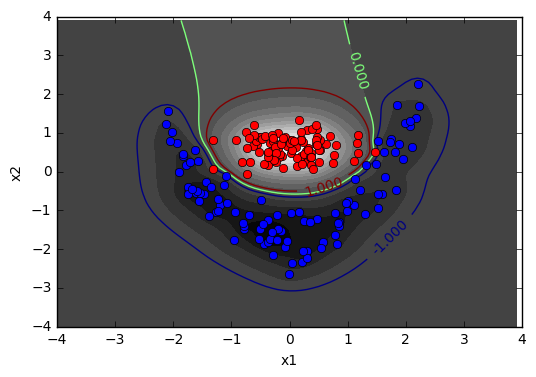

In [25]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)
#X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
X_ = np.concatenate((X, np.ones((len(X), 1))), axis=1)

K = rbf_kernel(X_, X_)
step = 1./lipschitz_constant(K,y)
mu_support, idx_support = ista_svm(K, y, grad, prox, C = 1, n_iter=100, step=step, callback=None)
b = 0

plot_classif(X, y, mu_support, idx_support, b, kernel = rbf_kernel)

#### Accelerated proximal gradient descent (FISTA)

In [26]:
def fista_svm(K, y, grad, prox, C, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    
    GG = np.multiply(np.multiply(y,K).T,y)
    
    mu = np.zeros(K.shape[0])
    z = np.zeros(K.shape[0])
    t = 1.

    for _ in range(n_iter):
        mu_new = prox(z - step * grad(GG,z),C)
        t_new = (1 + np.sqrt(1 + 4*t*t)) / 2
        z_new = mu_new + (t - 1) / t_new * (mu_new - mu)
        mu, z, t = mu_new, z_new, t_new

        # Update metrics after each iteration.
        if callback: 
            callback(mu)
    
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

Let's test FISTA

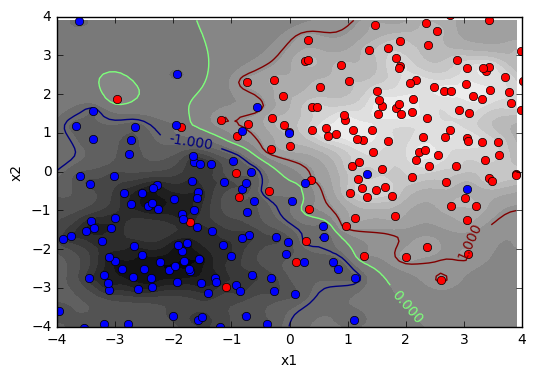

In [28]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)
#X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
X_ = np.concatenate((X, np.ones((len(X), 1))), axis=1)

K = rbf_kernel(X_, X_)
step = 1./lipschitz_constant(K,y)
mu_support, idx_support = fista_svm(K, y, grad, prox, C = 1, n_iter=100, step=step, callback=None)
b = 0

plot_classif(X, y, mu_support, idx_support, b, kernel = rbf_kernel)